# METHODOLOGY - DATA PREPROCESSING

- Textual Data Cleaning
    - remove tags
- Machine Translation
    - Google Api
    - google_trans_new
    - Many Apis
    - translators
- Data Split
    - stratified k-fold
- Data Augmentation
    - Contextual Word Embedding
    - Synonym Word Replacement
    - Naive Sampling (Over/under/mixed sampling)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import string
import re
import contractions
from tqdm import tqdm, trange
from math import ceil



# split - sampling
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE

# translation
# from google_trans_new import google_translator as Translator


# # augmentation
# import nlpaug.augmenter.char as nac
# import nlpaug.augmenter.word as naw
# import nlpaug.augmenter.sentence as nas
# import nlpaug.flow as naf
# from nlpaug.util import Action

# Data
- currently using sample Data
- use the real data later

In [2]:
raw_df = pd.read_csv('../data/project_data/final_annotated_data_for_augmentation.csv')
df = pd.DataFrame(data={'text':raw_df['text'], 'target':raw_df['emotions']})
emoji_df = pd.DataFrame(data={'text':raw_df['text'], 'emoticons':raw_df['emoticons'], 'emoticons_index':raw_df['emoticons_index']})
# raw_df = pd.read_csv('../data/project_data/tagalog_twts.csv')
# # df = pd.DataFrame(data={'text':raw_df['text'], 'target':raw_df['emotions']})
# emoji_df = pd.DataFrame(data={'text':raw_df['text'], 'emoticons':raw_df['emoticons'], 'emoticons_index':raw_df['emoticons_index']})


In [3]:
df

,text,target
0,rain blackout is this a heavens way of telling...,Angry
1,forreal making i acads i acads i really oroder...,Sad
2,aahhhh how did your acads go i missed you,Sad
3,omg bangbangcon is definitely a stress relieve...,Surprise
4,going to have no acads and minimal org works o...,Fear
...,...,...
45070,good narrow we now na edi we do not care that ...,Angry
45071,do not have me studying kase pure me nood in y...,Sad
45072,i do not have another space that i can study h...,Sad
45073,kajsfklajf you are jaejoong hard to study,Angry


In [4]:
emoji_df

,text,emoticons,emoticons_index
0,rain blackout is this a heavens way of telling...,😢,3
1,forreal making i acads i acads i really oroder...,NaN,NaN
2,aahhhh how did your acads go i missed you,NaN,NaN
3,omg bangbangcon is definitely a stress relieve...,NaN,NaN
4,going to have no acads and minimal org works o...,NaN,NaN
...,...,...,...
45070,good narrow we now na edi we do not care that ...,NaN,NaN
45071,do not have me studying kase pure me nood in y...,NaN,NaN
45072,i do not have another space that i can study h...,NaN,NaN
45073,kajsfklajf you are jaejoong hard to study,NaN,NaN


### Word Cloud

In [97]:
from wordcloud import WordCloud, STOPWORDS
def get_word_cloud(df, STOPWORDS = STOPWORDS):
    wc_df_key = [n for n in df.target.unique()]
    wc_df = {key:df[df.target == key] for key in wc_df_key}

    tweet_all = " ".join(review for review in df.text) 
    tweet_per_class = {"ALL": tweet_all}
    for key in wc_df:
        tweet_per_class.update({key.upper():" ".join(txt for txt in wc_df[key].text) })
    
    fig, ax = plt.subplots(len(tweet_per_class), 1, figsize  = (80, 45))#(50,50))
    

    wc_ls =[WordCloud(max_font_size=50, max_words=100, background_color="white",
                      width=450, height = 225,
                        stopwords=set(STOPWORDS)).generate(tweet_per_class[key]) for key in tweet_per_class]
    
    
    for i in range(len(wc_ls)):
        ax[i].imshow(wc_ls[i], interpolation='bilinear')
        ax[i].set_title(list(tweet_per_class.keys())[i], fontsize=30)
        ax[i].axis('off')
        
#         wc_emotion = ['all','angry', 'sad', 'surprise', 'fear', 'happy']# TODO base this on the wc title list
#         plt.savefig(f'../analysis/wordcloud_{wc_emotion[i]}.png') # TODO save the plots individually


In [98]:
STOPWORDS_with_filter = STOPWORDS
filter_words = ['lesson','acad', 'study', 'learn', 'studying', 'studied','acads','_','rt']
STOPWORDS_with_filter.update(filter_words)
STOPWORDS_with_filter

{'_',
 'a',
 'about',
 'above',
 'acad',
 'acads',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 'learn',
 'lesson',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or

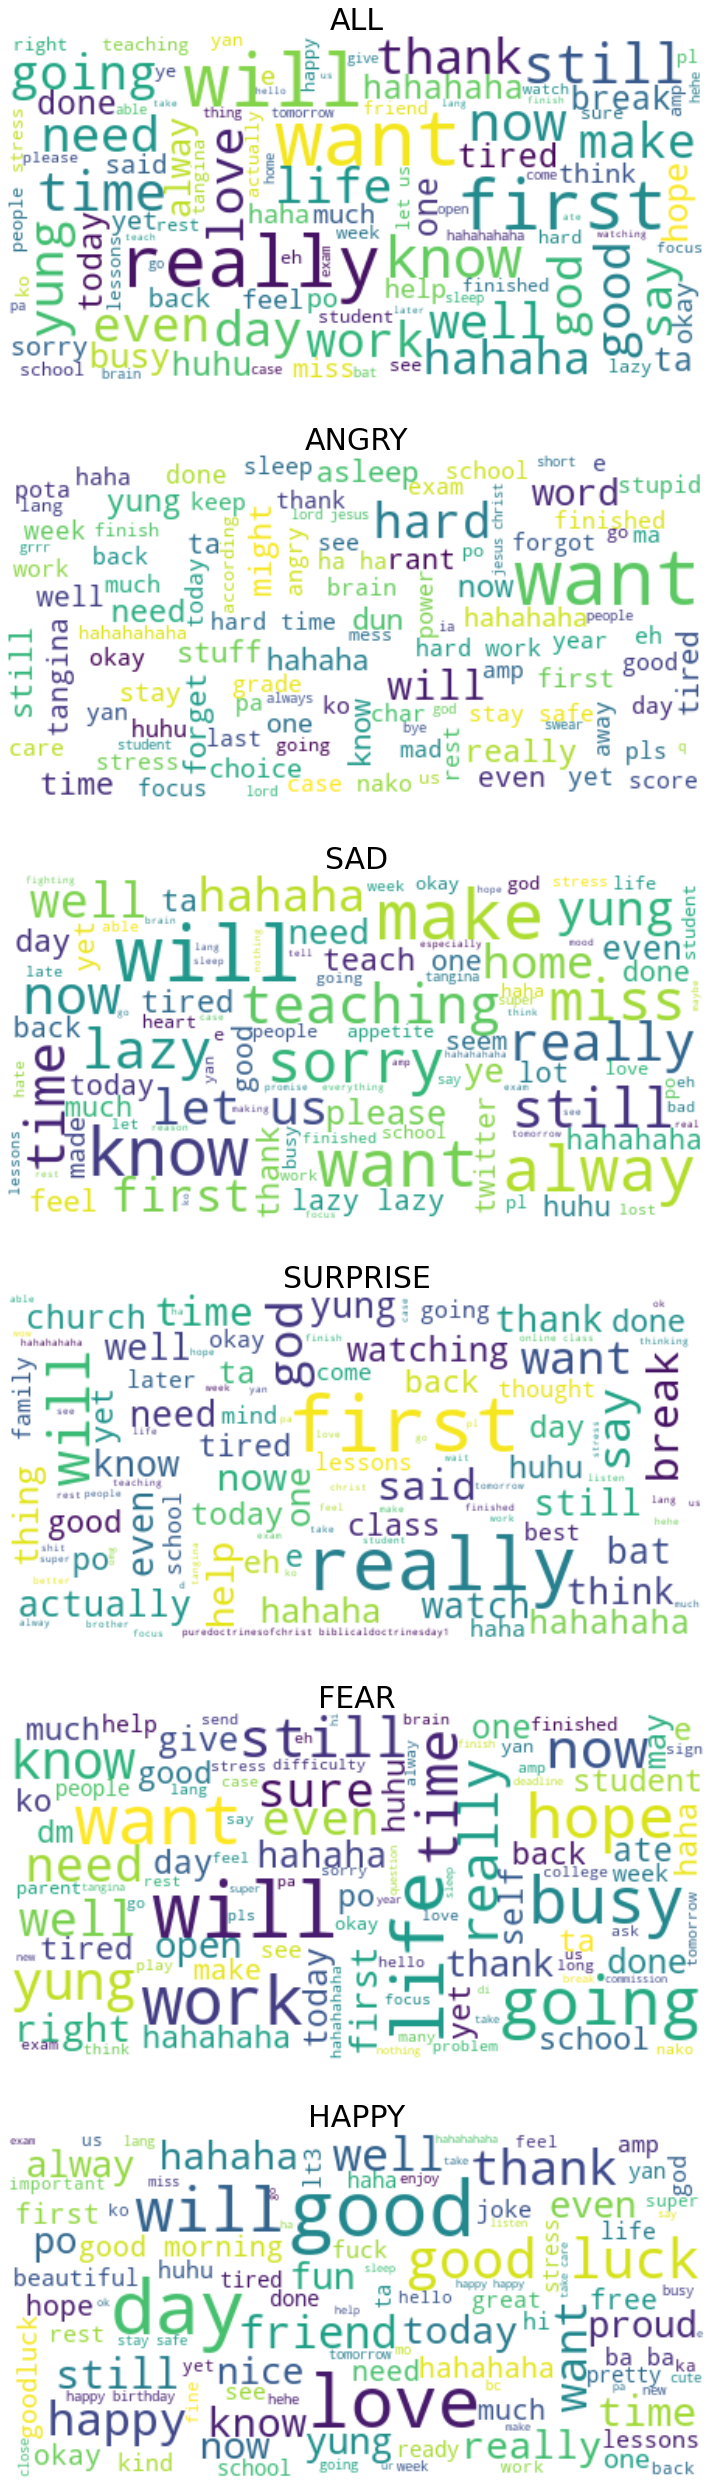

In [99]:
get_word_cloud(df, STOPWORDS=STOPWORDS_with_filter)

# get_word_cloud(emoji_df, STOPWORDS=STOPWORDS_with_filter)

### Distribution

In [9]:
def get_distribution(data):
    x_count = data.value_counts()
    for i in range(len(x_count)):
        print(f"{x_count.index[i]} = {x_count[i]} ({round((x_count[i]/sum(x_count)) * 100, 2)} %)")
    print(f"Total Count: {sum(x_count)} \n")    
    sns.barplot(x_count.index, x_count)
    plt.gca().set_ylabel('samples')

Fear = 12856 (28.52 %)
Surprise = 12248 (27.17 %)
Sad = 10885 (24.15 %)
Happy = 6032 (13.38 %)
Angry = 3054 (6.78 %)
Total Count: 45075 



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


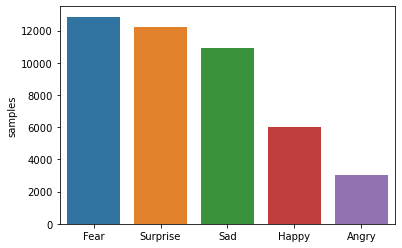

In [10]:
get_distribution(df.target)

### Under sampling

In [11]:
df.value_counts()

text                                                                                                                                                                                target  
  if you are just a student in your house when you really hahaha case quantity lesson                                                                                               Surprise    1
pota hahahahahahhaha such an impact of wind in neo city earlier dump I am haechan because I am tired of studying bwhahahahahahahahahahahahah                                        Angry       1
puyat that I am so puzzled but i do not study                                                                                                                                       Surprise    1
puyat that think you really study e                                                                                                                                                 Surprise    1
pvta lazy lazy aqo study hahahahaha

In [12]:

us_class_values = df.value_counts()
us_min_index = np.argmin(us_class_values)
us_min_index

0

### Split Data

In [13]:
x, y = df['text'], df['target']
# stratified randomsampling
def split_data(x, y, n_splits, shuffle):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True) 
    for train_index, test_index in kf.split(x, y):
        x_1, y_1 = x[train_index], y[train_index]
        x_2, y_2 = x[test_index], y[test_index]
    return kf, x_1, y_1, x_2, y_2
# 60:20:20 
train_kf, train_x, train_y, test_x, test_y = split_data(x=x, y=y, n_splits=7, shuffle=True) #
train_df = pd.DataFrame(data={'text':train_x , 'target':train_y}).reset_index()
val_kf, train_x, train_y, val_x, val_y =split_data(train_df['text'], train_df['target'], n_splits=6, shuffle=True)

In [14]:
train_x

1        forreal making i acads i acads i really oroder...
2                aahhhh how did your acads go i missed you
4        aaaack i just saw hmp thank you for always che...
5        buti just army rin adviser i both did not have...
7        i think about you all night too huhuhu fuck acads
                               ...                        
38631    good narrow we now na edi we do not care that ...
38632    do not have me studying kase pure me nood in y...
38633    i do not have another space that i can study h...
38634            kajsfklajf you are jaejoong hard to study
38635                       stream my first go study dance
Name: text, Length: 32197, dtype: object

Fear = 9183 (28.52 %)
Surprise = 8748 (27.17 %)
Sad = 7775 (24.15 %)
Happy = 4309 (13.38 %)
Angry = 2182 (6.78 %)
Total Count: 32197 



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


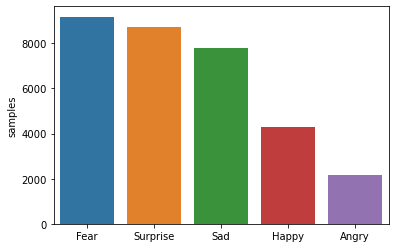

In [15]:
# train distribution
get_distribution(train_y)

Fear = 1836 (28.51 %)
Surprise = 1750 (27.18 %)
Sad = 1555 (24.15 %)
Happy = 862 (13.39 %)
Angry = 436 (6.77 %)
Total Count: 6439 



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


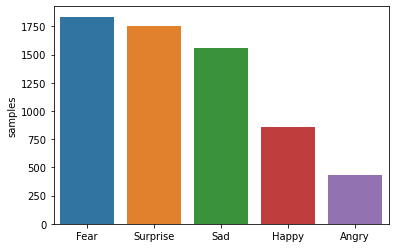

In [16]:
# test distribution
get_distribution(test_y)

Fear = 1837 (28.53 %)
Surprise = 1750 (27.18 %)
Sad = 1555 (24.15 %)
Happy = 861 (13.37 %)
Angry = 436 (6.77 %)
Total Count: 6439 



C:\Users\ijhre\anaconda3\envs\nlp_tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


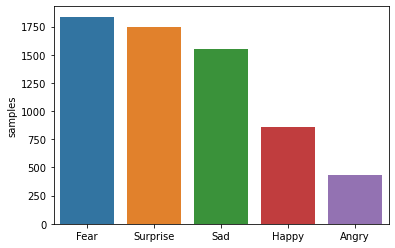

In [17]:
# val distribution
get_distribution(val_y)

## TRY OUT THESE SPLITS

- 70% train, 15% val, 15% test.
- 80% train, 10% val, 10% test. <- <b>TESTED</b>
- 60% train, 20% val, 20% test.


## TRY OUT DOWNSAMPLING

### Train Sample Count Resizing
train-val-test :: 60% :: 20% :: 20%

no augmentation or oversampling here!

we will turn it into 80% :: 10% :: 10% by text augmentation


# DownSampling

In [22]:
class_values = train_y.value_counts()
maj_index = np.argmax(class_values)
min_index = np.argmin(class_values)
class_values

Fear        9183
Surprise    8748
Sad         7775
Happy       4309
Angry       2182
Name: target, dtype: int64

In [26]:
class_values_dict = dict(class_values)
class_values_dict

{'Fear': 9183, 'Surprise': 8748, 'Sad': 7775, 'Happy': 4309, 'Angry': 2182}

In [23]:
min_count = class_values[min_index]
min_count

2182

In [32]:
us_train_df = pd.DataFrame({'text':train_x, 'sentiment':train_y})
us_train_df

,text,sentiment
1,forreal making i acads i acads i really oroder...,Sad
2,aahhhh how did your acads go i missed you,Sad
4,aaaack i just saw hmp thank you for always che...,Happy
5,buti just army rin adviser i both did not have...,Surprise
7,i think about you all night too huhuhu fuck acads,Surprise
...,...,...
38631,good narrow we now na edi we do not care that ...,Angry
38632,do not have me studying kase pure me nood in y...,Sad
38633,i do not have another space that i can study h...,Sad
38634,kajsfklajf you are jaejoong hard to study,Angry


In [52]:
trunc_us_train_df = pd.DataFrame()
for key in class_values_dict:
    trunc_us_train_df = trunc_us_train_df.append(us_train_df.loc[us_train_df['sentiment'] == key][:min_count])
trunc_us_train_df.sort_index(ascending=True, inplace=True)
trunc_us_train_df

,text,sentiment
1,forreal making i acads i acads i really oroder...,Sad
2,aahhhh how did your acads go i missed you,Sad
4,aaaack i just saw hmp thank you for always che...,Happy
5,buti just army rin adviser i both did not have...,Surprise
7,i think about you all night too huhuhu fuck acads,Surprise
...,...,...
38621,i have studied the beri slight eh hahahahhahahah,Angry
38622,hard to study filo sign language the conti of ...,Angry
38624,keep your child to listen to in the words of k...,Angry
38631,good narrow we now na edi we do not care that ...,Angry


In [53]:
trunc_us_train_df.to_csv(f'../data/project_data/data_train_undersampled_ratio.csv', index=False)

# Fully Balanced

In [ ]:
data_balance_ratio_dict = {'80':20, # 80% trainig + 20% val+test
                           '70':30, # 70% training + 30% val+test
                           '60':40 # 60% training + 40% val+test == original ratio
                          }
sel_balance_ratio = data_balance_ratio_dict['80']

def set_distribution_ratio(train_ratio = 20): # 20% we want this from 40% to 20% test+val ratio
    test_val_count = len(val_y) + len(test_y)
    test_val_ratio = train_ratio
    aug_total_size_count = (test_val_count * 100) / test_val_ratio # 100 is 100%
    aug_train_size_count = ceil(aug_total_size_count - test_val_count)
    return aug_train_size_count


aug_train_size_count = set_distribution_ratio(train_ratio = sel_balance_ratio)


In [44]:
# # distribution ratio for 80:10:10
# test_val_count = len(val_y) + len(test_y)
# test_val_ratio = 20 # 20% we want this from 40% to 20% test+val ratio
# aug_total_size_count = (test_val_count * 100) / test_val_ratio # 100 is 100%
# aug_train_size_count = ceil(aug_total_size_count - test_val_count)
# aug_train_size_count

51512

In [45]:
# 1st step : min and max based balance
class_values = train_y.value_counts()
maj_index = np.argmax(class_values)
min_index = np.argmin(class_values)

# the balanced min and max classes
class_dist = {}
init_balance_count = ceil((class_values[maj_index] - class_values[min_index])/2) + class_values[min_index]
for cls_name in class_values.index:
    class_dist.update({cls_name:init_balance_count})
class_dist    

{'Fear': 5683, 'Surprise': 5683, 'Sad': 5683, 'Happy': 5683, 'Angry': 5683}

In [46]:
# 2nd step : final balancing
total_class_size = sum(class_dist.values())
class_count = len(class_dist)

if aug_train_size_count > total_class_size:
    sample_space_left = aug_train_size_count - total_class_size
else:
    sample_space_left = total_class_size - aug_train_size_count
sample_space_left = ceil(sample_space_left / class_count)

class_dist = {}
for cls_name in class_values.index:
    class_dist.update({cls_name:sample_space_left + init_balance_count})

print(class_dist)
print(f"Total:{sum(class_dist.values())}")  

{'Fear': 10303, 'Surprise': 10303, 'Sad': 10303, 'Happy': 10303, 'Angry': 10303}
Total:51515


In [47]:
# show distribution
print("NEW COUNT")
for cls_name in class_dist:
    print(f"{cls_name} = {class_dist[cls_name]} ({round(class_dist[cls_name]/ sum(class_dist.values()) * 100, 2)}%)")
print("total = ", sum(class_dist.values()))

NEW COUNT
Fear = 10303 (20.0%)
Surprise = 10303 (20.0%)
Sad = 10303 (20.0%)
Happy = 10303 (20.0%)
Angry = 10303 (20.0%)
total =  51515


In [50]:
print("OLD COUNT")
old_class_dist = class_values.to_dict()
for cls_name in old_class_dist:
    print(f"{cls_name} = {old_class_dist[cls_name]} ({round(old_class_dist[cls_name]/ sum(old_class_dist.values()) * 100, 2)}%)")
print("total = ", sum(old_class_dist.values()))

OLD COUNT
Fear = 9184 (28.52%)
Surprise = 8748 (27.17%)
Sad = 7775 (24.15%)
Happy = 4308 (13.38%)
Angry = 2182 (6.78%)
total =  32197


In [51]:
# count the difference of old dist to new dist per class
print("DIFFERENCE COUNT")
old_class_dist = class_values.to_dict()
diff_class_count = {key: class_dist[key] - old_class_dist[key] for key in class_dist}
print(diff_class_count)

DIFFERENCE COUNT
{'Fear': 1119, 'Surprise': 1555, 'Sad': 2528, 'Happy': 5995, 'Angry': 8121}


In [52]:
# augmentation
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf
from nlpaug.util import Action

In [53]:
# for augmentation, need pytorch
aug_model = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action='substitute', device='cuda')

In [54]:
from tqdm import tqdm

### TODO: NEED TO READD THE EMOTICON

In [55]:
# populate sample size with indices / text 
class_indices = {key:train_y[train_y == key].index for key in train_y.unique()}
orig_class_dist = train_y.value_counts().to_dict()
max_sample_count= list(class_dist.values())[0]

# get the sample indices
aug_texts = {}
for cls_name, counts in diff_class_count.items(): 
    print(f"Number of {cls_name} samples to augment :: {counts}")
    if counts == orig_class_dist[cls_name]:
        print(f"{counts} == 0 :: no augmentation needed")
        temp = np.array(train_x.loc[class_indices[cls_name]])
    elif counts < 0: #orig_class_dist[cls_name]:
        print(f"{counts} < 0 :: no augmentation needed")
        temp = np.array(train_x.loc[class_indices[cls_name][:counts]])
    else:
        print(f"Augmenting {counts} samples")
        idx = list(class_indices[cls_name])
        c= list(class_dist.values())[0] - len(idx) # how many to augment
        i = 0
        temp = np.array(train_x.loc[idx])
        print("init temp:",len(temp))
        
        pbar = tqdm(total = c, position=0, leave=True) # augmentation timer
        while 0 < c:
            c -= 1
            if i < len(temp):# augment here,
                temp = np.append(temp, aug_model.augment(temp[i]))
                i += 1
            else: i = 0
            pbar.update(1) # to update the timer
        pbar.close()
        
    aug_texts.update({cls_name: temp})
    print(f"New {cls_name} sample counts :: {len(temp)}")
    print(f"===========================================\n")


  0%|                                                                  | 0/1119 [00:00<?, ?it/s]

Number of Fear samples to augment :: 1119
Augmenting 1119 samples
init temp: 9184


  0%|                                                          | 1/1555 [00:00<04:49,  5.38it/s]

New Fear sample counts :: 10303

Number of Surprise samples to augment :: 1555
Augmenting 1555 samples
init temp: 8748


  0%|                                                                  | 0/2528 [00:00<?, ?it/s]

New Surprise sample counts :: 10303

Number of Sad samples to augment :: 2528
Augmenting 2528 samples
init temp: 7775


  0%|                                                                  | 0/5995 [00:00<?, ?it/s]

New Sad sample counts :: 10303

Number of Happy samples to augment :: 5995
Augmenting 5995 samples
init temp: 4308


  0%|                                                                  | 0/8121 [00:00<?, ?it/s]

New Happy sample counts :: 10303

Number of Angry samples to augment :: 8121
Augmenting 8121 samples
init temp: 2182


100%|███████████████████████████████████████████████████████| 8121/8121 [33:30<00:00,  4.04it/s]

New Angry sample counts :: 10303



In [56]:
aug_df = pd.DataFrame(columns=['text', 'sentiment'])
aug_df['text'] = [y for x in list(aug_texts.values()) for y in x]
aug_df['sentiment'] = [key for key in aug_texts for i in range(len(aug_texts[key]))]
aug_df 

,text,sentiment
0,going to have no acads and minimal org works o...,Fear
1,nastress me suddenly at work and acads cake an...,Fear
2,super busy on acads like wth not only magenjoy...,Fear
3,i have finished accounting because I am having...,Fear
4,_ot8 so you know how i get rid of life eme bac...,Fear
...,...,...
51510,but how i am employed me know'longer feel i kn...,Angry
51511,i nip at his 2 cross street bungads in which i...,Angry
51512,maybe after more grief you do either way i no'...,Angry
51513,world day i don't make the air but most survive,Angry


In [57]:
to_save ={
    "train":pd.DataFrame(data={'text':aug_df['text'], 'sentiment':aug_df['sentiment']}),
    "val":pd.DataFrame(data={'text':val_x, 'sentiment':val_y}),
    "test":pd.DataFrame(data={'text':test_x, 'sentiment':test_y}),
}

for key in to_save:
    to_save[key].to_csv(f'../data/project_data/data_{key}.csv', index=False)

In [ ]:

to_save ={
    "train":pd.DataFrame(data={'text':aug_df['text'], 'sentiment':aug_df['sentiment']}),
    "val":pd.DataFrame(data={'text':val_x, 'sentiment':val_y}),
    "test":pd.DataFrame(data={'text':test_x, 'sentiment':test_y}),
}

for key in to_save:
    to_save[key].to_csv(f'../data/project_data/data_{key}_{str(100-sel_balance_ratio)}_ratio.csv', index=False)